<a href="http://www.stfc.ac.uk/"> <img src="../../img/STFCLargeColour.jpg" width="50%" align="left"/></a>
<a href="https://www.addopt.org/"><img src="../../img/ADDoPT-logo-MAIN-with-text.png" width="300" height="200" align="right"/></a>


# Support Vector Classifiers

--------------------------------

This lesson focusses on using a Support Vector Machine for classification.

For the example, we have selected all the approved drugs from Chembl, and a random sample of about the same size of other molecules. Some of these molecules are very unlike drugs, so this is the "easy" version of the druglikeness problem. Thanks to the EBI for this dataset.

In [1]:
import sys
import math
import numpy
sys.path.append('../../lib/')
import pandas as pd
import pickle
import Kernel

from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split

from rdkit import Chem
import pandas as pd

import matplotlib.pyplot as plt
'imported'

'imported'

## Kernel Methods
Most classifiers work in feature space. So most of our pages find a suitable list of features and calculate a vector of features for each molecule in the training set. Kernel methods use a different approach. A kernel function is a measure of similarity between molecules. [Support Vector Regression](SVR.ipynb), [Gaussian Process Regression](Optional/GPR.ipynb), etc are methods that use a supplied kernel function to build a predictive model.

In this notebook we will work through an example of Support Vector Classification. Then we'll [look at the theory behind it](Kernels.ipynb).


In [3]:
#read in the data set
training_set = pd.read_pickle("../../model_data/chembl21_drug_easy_train.p")
test_set = pd.read_pickle("../../model_data/chembl21_drug_easy_test.p")

training_set.groupby('max_phase').count()

main_component  molecule  molregno  pref_name  first_approval  \
max_phase                                                                  
0                    2254      2254      2254       2254               0   
1                      56        56        56         56               0   
2                     251       251       251        251               0   
3                     273       273       273        273               0   
4                    1728      1728      1728       1728            1686   

           usan_year  availability_type  indication_class  standard_inchi  \
max_phase                                                                   
0               2254               2254                 0            2254   
1                 56                 56                 0              56   
2                251                251                 0             251   
3                273                273                 0             273   
4               1208               1728                 0            1728   

           canonical_smiles  num_ro5_violations  qed_weighted  Drug  value  
max_phase                                                                   
0                      2254                2201          2201  2254   2254  
1                        56                  55            55    56     56  
2                       251                 239           239   251    251  
3                       273                 258           258   273    273  
4                      1728                1619          1619  1728   1728

## The model

We will use Sklearn's [$\nu$-Support Vector Classification](http://scikit-learn.org/stable/modules/generated/sklearn.svm.NuSVC.html).

It has the parameter nu : An upper bound on the fraction of training errors and a lower bound of the fraction of support vectors. Should be in the interval (0, 1]. The default is 0.5.

First, calculate the Gram Matrix. We will discuss what this means [later](Kernels.ipynb). This takes a while.


In [4]:
import time
from rdkit import DataStructs

def gram_matrix(X, Y=None):
    if Y:
        pass
    else:
        Y = X
    gm = numpy.zeros([len(X), len(Y)], dtype=numpy.float64) 
    for i in range(0, len(X)):
        for j in range(0, len(Y)):
            gm[i, j] =  DataStructs.FingerprintSimilarity(X[i],Y[j], 
                metric=DataStructs.cDataStructs.TanimotoSimilarity)
    return numpy.array(gm, dtype=numpy.float64)


fingerprint = lambda m: Chem.rdmolops.RDKFingerprint(m, maxPath=3)
training_fp = training_set['molecule'].apply(fingerprint)
kernel = Kernel.MoleculeKernel(fingerprint=fingerprint)  
start =  time.perf_counter()
training_gm = gram_matrix(list(training_fp))
print( 'Building Gram Matrix took: '+str( time.perf_counter()-start)+'s' )

Building Gram Matrix took: 47.48190638399956s


In [6]:
from sklearn.svm import NuSVC

# see http://scikit-learn.org/stable/modules/generated/sklearn.svm.NuSVC.html 
model = svm.NuSVC(kernel='precomputed', # see next presentation
                nu=0.3, # default is 0.5 , but see below
                verbose=True,
                probability = True
) 
training_y = training_set.max_phase == 4
model.fit(
        training_gm,
        training_y,  # dependent values, to be predicted
        # could supply sample_weight
)

[LibSVM]

NuSVC(cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma='auto',
   kernel='precomputed', max_iter=-1, nu=0.3, probability=True,
   random_state=None, shrinking=True, tol=0.001, verbose=True)

## Predicting classes  

Now we have trained our model using the training data, we can look at predictions using the test data.

The score used is accuracy. 

In [8]:
test_y = test_set.max_phase == 4
test_fp = test_set['molecule'].apply(fingerprint)
test_gm = gram_matrix(list(test_fp), list(training_fp))
# pickle the gram matrices for future use
with open( "../../model_data/chembl21_drug_easy_gm_train.p", "wb" ) as f:
    pickle.dump( ( # tuple of the data we need
        training_fp, training_gm, training_y, test_fp, test_gm, test_y, 
        training_set['pref_name'], training_set['max_phase']==4, training_set['molecule'], test_set['molecule'] 
    ), f )
                
model.score(test_gm, test_y) # accuracy

0.7964026023727516

## Grid search for optimum $\nu$
If $\nu$ is too small, it cannot fit the training set. If it is too large, it overfits.


In [9]:
from sklearn.model_selection import GridSearchCV

#let's use 10-fold cross validation, iterating through a range of values for nu.

parameters = {
    'nu': numpy.arange(0.005, 0.02, 0.005).tolist() +numpy.arange(0.05, 0.5, 0.05).tolist() # default 0.5 is infeasible
    #, Could: 'tol': numpy.arange(0.0005, 0.002, 0.0005) # default is 0.001
}

grid_search = GridSearchCV(model,parameters,cv=10, scoring="roc_auc")
grid_search.fit(training_gm,training_y)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

GridSearchCV(cv=10, error_score='raise',
       estimator=NuSVC(cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma='auto',
   kernel='precomputed', max_iter=-1, nu=0.3, probability=True,
   random_state=None, shrinking=True, tol=0.001, verbose=True),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'nu': [0.005, 0.01, 0.015, 0.05, 0.1, 0.15000000000000002, 0.2, 0.25, 0.3, 0.35000000000000003, 0.4, 0.45]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

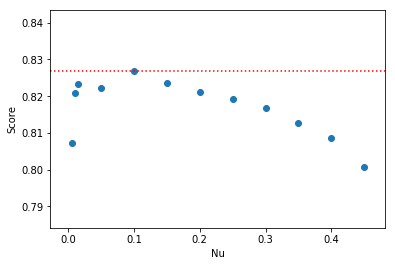

Maximum score is 82.69 % achieved using nu = 0.1
Optimised model is:
 NuSVC(cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma='auto',
   kernel='precomputed', max_iter=-1, nu=0.1, probability=True,
   random_state=None, shrinking=True, tol=0.001, verbose=True)


In [10]:
#all our scores are retained here:
mean_auc_scores = grid_search.cv_results_["mean_test_score"]

#let's visualise this.
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

max_auc = max(mean_auc_scores)
best_nu = parameters['nu'][ numpy.where(mean_auc_scores==max_auc)[0][0] ]

plt.scatter(parameters['nu'],mean_auc_scores)
plt.xlabel("Nu")
plt.ylabel("Score")
#plt.ylim(0.970, 0.980)
plt.axhline(y=max_auc, color="red",linestyle="dotted")
plt.show()

print("Maximum score is %s %% achieved using nu = %s" %(round(max_auc*100,2),best_nu))

print("Optimised model is:\n %s"%grid_search.best_estimator_)

### Refit the optimised model to whole training set

The model is nearly as good with nu=0.1, and as we will see [later](SVM.ipynb) this is less likely to be overfitted. 

In [12]:
import models
from sklearn.metrics import roc_auc_score


model = svm.NuSVC(kernel='precomputed',  
                nu=0.1,  
                verbose=True,
                probability=True
) 

model.fit(
        training_gm, # Gram matrix, see next presentation
        training_y,  # dependent values, to be predicted
        # could supply sample_weight
)

predicted = model.predict(test_gm)
print("\nAccuracy: %0.4f" %accuracy_score(test_y, predicted))

prob = model.predict_proba(test_gm)[:,1]
print("ROC AUC: %0.4f" %roc_auc_score(test_y, prob))

# save the model.
models.saveModel(model, filename="../../model_data/nuSVC")

[LibSVM]
Accuracy: 0.8041
ROC AUC: 0.8594


FileNotFoundError: [Errno 2] No such file or directory: '../model_data/../../model_data/nuSVC.pkl'

## See the fraction of "Support Vectors"
The definition is explained [here](SVM.ipynb).

In [13]:
len(model.support_)/len(training_y)

0.6266988163086366

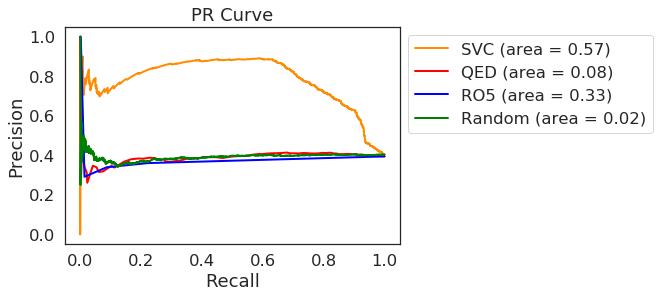

In [14]:
from sklearn.metrics import precision_recall_curve, auc
import random

scores = model.decision_function(test_gm)
#fpr, tpr, _ = roc_curve(test_set.max_phase == 4, predicted)
precision, recall, _ = precision_recall_curve(test_set.max_phase == 4, scores, pos_label=True)
pr_auc = auc(precision, recall, reorder=True)

# where QED is available, use it for comparison
test_qed = test_set[ test_set['qed_weighted'].notnull()] 
precision_qed, recall_qed, _ = precision_recall_curve(test_qed['max_phase'] == 4, test_qed['qed_weighted'], pos_label=True)
pr_auc_qed = auc(precision_qed, recall_qed, reorder=True)

# and Lipinski
test_ro5 = test_set[ test_set['num_ro5_violations'].notnull()] 
precision_ro5,recall_ro5, _ = precision_recall_curve(test_ro5['max_phase'] == 4, test_ro5['num_ro5_violations'], pos_label=True)
pr_auc_ro5 = auc(precision_ro5, recall_ro5, reorder=True)


# and random predictor
precision_rand,recall_rand, _ = precision_recall_curve(test_set['max_phase'] == 4, 
                                                       [random.random() for i in range(0, len(test_y)) ], 
                                                       pos_label=True)
pr_auc_rand = auc(precision_rand, recall_rand, reorder=True)


# now plot
plt.figure()
lw = 2
plt.plot(recall, precision, color='darkorange',
         lw=lw, label='SVC (area = %0.2f)' % pr_auc)
plt.plot(recall_qed, precision_qed, color='red',
         lw=lw, label='QED (area = %0.2f)' % pr_auc_qed)
plt.plot(recall_ro5, precision_ro5, color='blue',
         lw=lw, label='RO5 (area = %0.2f)' % pr_auc_ro5)
plt.plot(recall_rand, precision_rand, color='green',
         lw=lw, label='Random (area = %0.2f)' % pr_auc_rand)

#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title('PR Curve')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

Note that the score on the test set is five percentage points worse than the cross-validation score. Cross validation provides incomplete protection against overfitting.

Bickerton's QED or Lipinski's Rule of Five perform poorly because they both recognise as drug-like a lot of failed molecules. (However, they were not intended as classifiers but as guides to action.)

Our classifier successfully recognises a small number of drugs, but then also sees as druglike a group which are mostly non-drugs. We will investigate them [later](Visualization.ipynb). There is a cutoff value which gives a precision of 0.8 and a recall of 0.5. But then the remaining fifty percent of the drugs are not successfully recognised as druglike.


## Exercise: Plot ROC Curve


In [ ]:
 # your code here

## Exercise: optimise tolerance
The default is  tol=0.001. This is used to decide when the iterations can stop. With nu=0.1, can you find a better value for tolerance?

Later, we will see how to do a grid search for two parameters at once.


[Up](../Welcome.ipynb) 
[Previous](SVM.ipynb) [Next](SVR.ipynb)


Copyright STFC 2018